# PREDICTION OF POKEMON TYPES USING POKEMON DATASET 


<img src="pokemon.png" style="width:500px">

The dataset used in this project contains 800 different pokemons which belong to seven generations. The project focuses on predicting the types of pokemon and whether 
the pokemon are legendary or not based on machine learning techniques. In particular, we will take advantage of:
    1. Knn algorithm
    2. Neural  network

There are in total, 18 different types of pokemon that are present in the dataset. The pokemon is said to be legendary if the value is 1
and is not legendary if the value is 0. The features influencing the type of the pokemon are the abilities and the strength of the pokemon
against other pokemon. The features that determine if the pokemon is legendary or not is the attack,defense,special attack,special defense,HP,
height,weight and experience. 640 data points are used for training and 160 for testing the model. 
Alright, lets catch 'em all!

# Loading the data

In [2]:
# Import initial libraries and settings
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

#import the data
data=pd.read_csv("pokemon.csv")

data1=data.drop(['japanese_name','percentage_male','pokedex_number','type2','classfication'],axis=1)
data1.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,height_m,hp,name,sp_attack,sp_defense,speed,type1,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0.7,45,Bulbasaur,65,65,45,grass,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,1.0,60,Ivysaur,80,80,60,grass,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,2.0,80,Venusaur,122,120,80,grass,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0.6,39,Charmander,60,50,65,fire,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,1.1,58,Charmeleon,80,65,80,fire,19.0,1,0


# Data visualization
What is the proportion of each type of pokemon in our dataset?


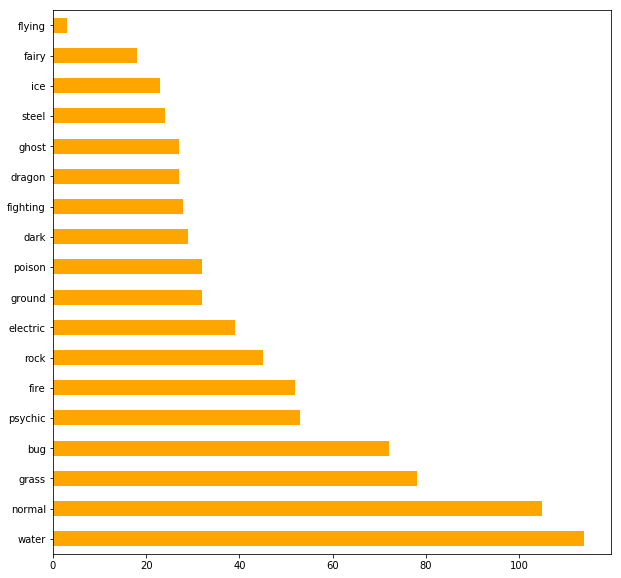

In [2]:
data['type1'].value_counts().plot(kind='barh', color='orange',figsize=(10,10))

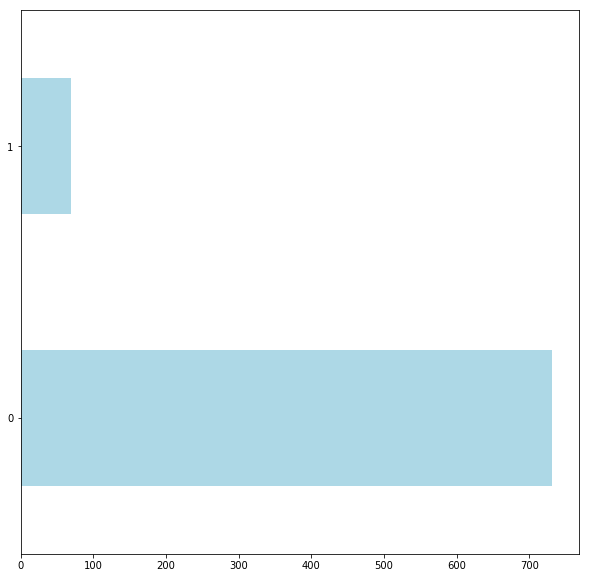

In [39]:
data['is_legendary'].value_counts().plot(kind='barh', color='lightblue',figsize=(10,10))

# Data preprocessing

Here, the abilities of the pokemon are a list of string values.These are to be converted into binary equivalents.
Hence,multilabelbinarizer can be used which tranforms the list into a binary matrix having 227 columns since there are 227 distinct values in the list.

In [3]:
ability=[]
for i in data1['abilities']:
    x = i[1:-2]
    
    x = x.replace("'","")
   
    x= x.replace(" ", "")
   
    y = x.split(',')
    
    ability.append(y)
df = pd.DataFrame(
    {'abilities':
        ability
    }, columns=['abilities'])

s = df['abilities']

mlb = MultiLabelBinarizer()

X=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
x=pd.DataFrame(X)

### Principal Component Analysis (PCA)

PCA is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set. Since all 227 columns are important, I have used PCA to tranform it into 10 columns.

In [4]:
newdf = pd.concat([x,data1],axis=1)


pca = PCA()  
features1 = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_
explained_variance
pca = PCA(n_components=10)  
features1 = pca.fit_transform(features1)

Upon observing the dataset,there were few values with Nan which indicates missing values. We have to replace these values and this can be done by taking the mean of the row and replacing Nan with this mean. Furhter, few columns are dropped in order to get the clean dataset. 

In [5]:
features=newdf.drop(['type1','name','abilities'],axis=1)
features.fillna(features.mean(), inplace=True)



Okay, lets get to the algorithms. Since there are two target values considered, two models are built in both neural network and KNN. We begin with predicting the accuracy using KNN algorithm.

## KNN, I choose you! <img src="pokeballgif.gif" style="width:450px">

We will first predict the accuracy for the target 'is_legendary'. The various features affecting this can be determined by the correlation. The pearson correlation and the heat map is as follows,

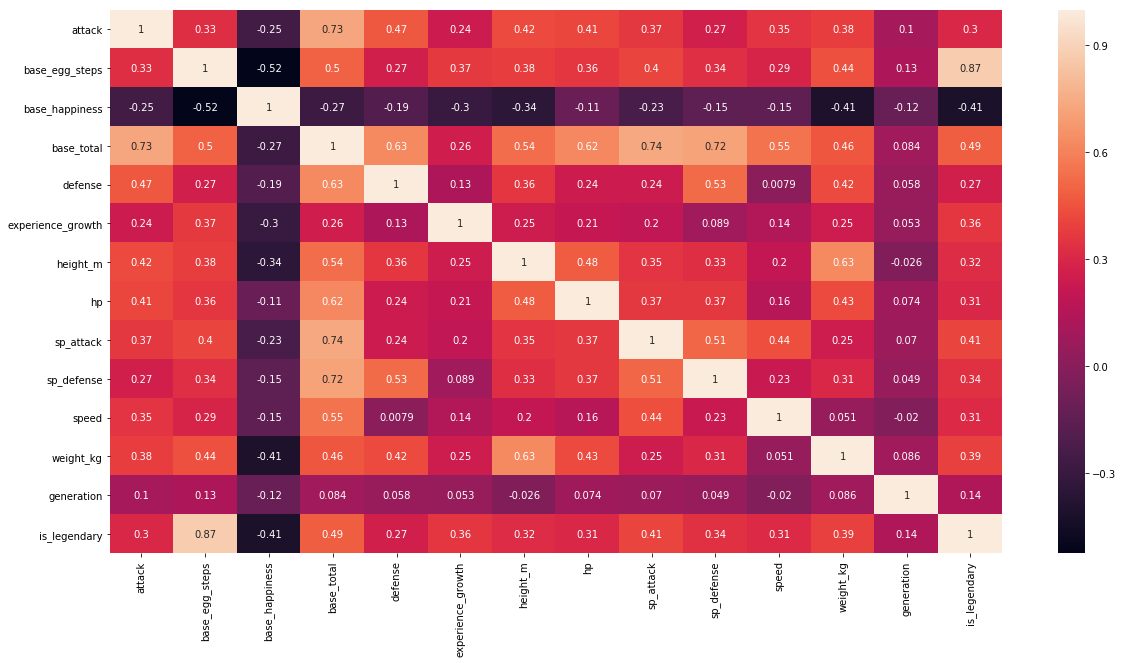

In [83]:
data2=data1.drop(['abilities','against_bug','against_dark','against_dragon','against_electric','against_fairy','against_fight','against_fire','against_flying','against_ghost','against_grass','against_ground','against_ice','against_normal','against_poison','against_psychic','against_rock','against_steel','against_water','capture_rate'],axis=1)
data2
abs(data2['is_legendary']).sort_values(ascending=False)
corr = data2.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True)
plt.show()

We see that there is some correlation with the following stats
    Height and weight
    Base Experience and Special Attack / Special Defense
    Base Experience and Total (the stronger a Pokemon, the more experience you receive)
Keeping this in view, we will select the necessary features for our prediction.

In [95]:
features2= pd.DataFrame(features.iloc[:,245:-2])
features2=features2.drop(['capture_rate'],axis=1)
features2=pd.DataFrame(features2)


In [96]:
#normalization of the data.
features2=(features2-features2.min())/(features2.max()-features2.min())
features2=np.array(features2)

In [97]:
target=pd.DataFrame(newdf['is_legendary'])
target=np.array(target)
xtrain, xtest, ytrain, ytest = train_test_split(features2,target, test_size=0.3)

features2 contains all the necessary features for our prediction and target contains 'is_legendary'. 70% of the data is used on training and 30% for testing.
The Knn algorithm is shown below. 15 neighbours are considered.

In [10]:
def euclid_distance(train_point, given_point):
    distance = np.sum((train_point-given_point)**2)
    return np.sqrt(distance)


# Calculate distance from a given point to all other points
# and keep track of the respective classes for those distances
# and eventually return sorted list of distances
def calc_distance_from_all(all_points, given_point, predictions):
    all_distances = []
    for i, each in enumerate(all_points):
        distance = euclid_distance(each, given_point)
        all_distances.append((distance,int(predictions[i])))
    all_distances.sort(key=lambda tup: tup[0])
    return all_distances



# Get the "n" defined neighbours from a list of sorted distances
def get_neighbours(distances, count):
    return distances[:count]




# Takes a given point and predicts the class based on all other points
def predict(all_points, given_point, predictions):
    distances = calc_distance_from_all(all_points,given_point,predictions)
    neighbours = get_neighbours(distances, 17)
    
    op = [row[-1] for row in neighbours]
    prediction = max(set(op), key=op.count)
    return prediction



# Get how accurate our system is based on a new set of test points
# for which we already know the right answer to
def accuracy(basex, basey, testx, testy):
    correct = 0 
    
    for i in range(len(testx)):
        p = predict(basex, testx[i], basey)
        if p == testy[i]:
            correct += 1
            
    return f"Accuracy: {correct*100/len(testy)}%"

In [99]:
accuracy(xtrain,ytrain,xtest,ytest)

'Accuracy: 98.7551867219917%'

The accuracy for predicting the legendary pokemon is 98.75%. 

We will now predict the accuracy for the target 'type1' to predict the type of the pokemon. The feautures needed for this are the ability of the pokemon and the strength against other types or pokemon. We have already preprocessed the data and used PCA to convert the 227 columns into 10,which is present in a variable called features1. features2 contains the strength of the pokemon against other pokemon. 

In [7]:
features2= pd.DataFrame(features.iloc[:,227:-15])
features1=pd.DataFrame(features1)
features2=pd.DataFrame(features2)
ft=pd.concat([features1,features2],axis=1)
ft=(ft-ft.min())/(ft.max()-ft.min())
ft=np.array(ft)



The target consists of string values which have to be converted into integers. Thus,cat.codes is used to convert the string classes into integer class values.

In [9]:
target1=newdf['type1']
target=target1.astype("category").cat.codes
target=np.array(target)
xtrain, xtest, ytrain, ytest = train_test_split(ft,target, test_size=0.3)


In [11]:
accuracy(xtrain,ytrain,xtest,ytest)

'Accuracy: 82.15767634854772%'

Upon execution of the KNN algorithm for the new set of features and target, the accuracy to predict the type is 82.15% with 15 neighbours. 
KNN algorithm gives a good accuracy for both the targets. 

Now, let us explore neural networks for our data. 

# Good job KNN. Lets go Neural networks!

### Training the data.
As with KNN, we will build two networks for predicting type and legendary pokemon. We will start by building a model with the target as 'type1' and features as abilities and strength against other pokemon.

In [6]:
features.fillna(features.mean(), inplace=True)
features2= pd.DataFrame(features.iloc[:,227:-15])
features1=pd.DataFrame(features1)
features2=pd.DataFrame(features2)
ft=pd.concat([features1,features2],axis=1)

ft=(ft-ft.min())/(ft.max()-ft.min())
ft=np.array(ft)

In [7]:
target1=pd.DataFrame(newdf['type1'])
target1=pd.get_dummies(target1)
target=np.array(target1)
xtrain,xtest,ytrain,ytest=train_test_split(ft,target, test_size=0.3)

In [8]:
model = keras.Sequential([
    keras.layers.Dense(106, activation=tf.nn.tanh,
                       input_shape=(xtrain.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(18, activation=tf.nn.softmax)
])

In [9]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [10]:
history= model.fit(xtrain, ytrain, epochs=200, validation_split=0.2, verbose=2)

Train on 448 samples, validate on 112 samples
Epoch 1/200
 - 0s - loss: 2.8751 - acc: 0.0759 - val_loss: 2.7542 - val_acc: 0.1696
Epoch 2/200
 - 0s - loss: 2.6072 - acc: 0.2522 - val_loss: 2.6534 - val_acc: 0.2143
Epoch 3/200
 - 0s - loss: 2.4656 - acc: 0.2589 - val_loss: 2.5023 - val_acc: 0.3036
Epoch 4/200
 - 0s - loss: 2.3273 - acc: 0.4040 - val_loss: 2.3737 - val_acc: 0.3214
Epoch 5/200
 - 0s - loss: 2.1706 - acc: 0.4688 - val_loss: 2.2222 - val_acc: 0.4375
Epoch 6/200
 - 0s - loss: 2.0113 - acc: 0.5022 - val_loss: 2.0697 - val_acc: 0.4732
Epoch 7/200
 - 0s - loss: 1.8432 - acc: 0.5938 - val_loss: 1.9107 - val_acc: 0.5179
Epoch 8/200
 - 0s - loss: 1.6807 - acc: 0.6228 - val_loss: 1.7610 - val_acc: 0.5625
Epoch 9/200
 - 0s - loss: 1.5328 - acc: 0.6429 - val_loss: 1.6297 - val_acc: 0.5804
Epoch 10/200
 - 0s - loss: 1.3991 - acc: 0.6496 - val_loss: 1.4986 - val_acc: 0.5982
Epoch 11/200
 - 0s - loss: 1.2855 - acc: 0.6763 - val_loss: 1.3997 - val_acc: 0.6250
Epoch 12/200
 - 0s - loss: 1

Epoch 97/200
 - 0s - loss: 0.0970 - acc: 0.9710 - val_loss: 0.3492 - val_acc: 0.8839
Epoch 98/200
 - 0s - loss: 0.0951 - acc: 0.9732 - val_loss: 0.3433 - val_acc: 0.8929
Epoch 99/200
 - 0s - loss: 0.0942 - acc: 0.9732 - val_loss: 0.3420 - val_acc: 0.9018
Epoch 100/200
 - 0s - loss: 0.0934 - acc: 0.9799 - val_loss: 0.3497 - val_acc: 0.9018
Epoch 101/200
 - 0s - loss: 0.0912 - acc: 0.9732 - val_loss: 0.3425 - val_acc: 0.9018
Epoch 102/200
 - 0s - loss: 0.0900 - acc: 0.9754 - val_loss: 0.3534 - val_acc: 0.9018
Epoch 103/200
 - 0s - loss: 0.0904 - acc: 0.9754 - val_loss: 0.3489 - val_acc: 0.8929
Epoch 104/200
 - 0s - loss: 0.0887 - acc: 0.9754 - val_loss: 0.3467 - val_acc: 0.9018
Epoch 105/200
 - 0s - loss: 0.0890 - acc: 0.9799 - val_loss: 0.3555 - val_acc: 0.8929
Epoch 106/200
 - 0s - loss: 0.0854 - acc: 0.9732 - val_loss: 0.3429 - val_acc: 0.9018
Epoch 107/200
 - 0s - loss: 0.0868 - acc: 0.9754 - val_loss: 0.3441 - val_acc: 0.9018
Epoch 108/200
 - 0s - loss: 0.0861 - acc: 0.9777 - val_lo

Epoch 193/200
 - 0s - loss: 0.0454 - acc: 0.9933 - val_loss: 0.3707 - val_acc: 0.9018
Epoch 194/200
 - 0s - loss: 0.0442 - acc: 0.9888 - val_loss: 0.3840 - val_acc: 0.9018
Epoch 195/200
 - 0s - loss: 0.0458 - acc: 0.9911 - val_loss: 0.3712 - val_acc: 0.8929
Epoch 196/200
 - 0s - loss: 0.0439 - acc: 0.9933 - val_loss: 0.3761 - val_acc: 0.9018
Epoch 197/200
 - 0s - loss: 0.0465 - acc: 0.9866 - val_loss: 0.3798 - val_acc: 0.8929
Epoch 198/200
 - 0s - loss: 0.0456 - acc: 0.9911 - val_loss: 0.3747 - val_acc: 0.9018
Epoch 199/200
 - 0s - loss: 0.0450 - acc: 0.9866 - val_loss: 0.3851 - val_acc: 0.8929
Epoch 200/200
 - 0s - loss: 0.0437 - acc: 0.9911 - val_loss: 0.3837 - val_acc: 0.9018


In [11]:
model.fit(xtest,ytest,epochs=100)

Epoch 1/100
241/241 [==============================] - 0s 145us/step - loss: 0.2628 - acc: 0.9129
Epoch 2/100
241/241 [==============================] - 0s 73us/step - loss: 0.1901 - acc: 0.9212
Epoch 3/100
241/241 [==============================] - 0s 73us/step - loss: 0.1596 - acc: 0.9502
Epoch 4/100
241/241 [==============================] - 0s 62us/step - loss: 0.1370 - acc: 0.9710
Epoch 5/100
241/241 [==============================] - 0s 52us/step - loss: 0.1204 - acc: 0.9710
Epoch 6/100
241/241 [==============================] - 0s 52us/step - loss: 0.1091 - acc: 0.9751
Epoch 7/100
241/241 [==============================] - 0s 52us/step - loss: 0.0991 - acc: 0.9793
Epoch 8/100
241/241 [==============================] - 0s 52us/step - loss: 0.0905 - acc: 0.9793
Epoch 9/100
241/241 [==============================] - 0s 73us/step - loss: 0.0869 - acc: 0.9793
Epoch 10/100
241/241 [==============================] - 0s 62us/step - loss: 0.0812 - acc: 0.9751
Epoch 11/100
241/241 [======

241/241 [==============================] - 0s 62us/step - loss: 0.0278 - acc: 0.9917
Epoch 84/100
241/241 [==============================] - 0s 62us/step - loss: 0.0278 - acc: 0.9917
Epoch 85/100
241/241 [==============================] - 0s 52us/step - loss: 0.0280 - acc: 0.9917
Epoch 86/100
241/241 [==============================] - 0s 73us/step - loss: 0.0291 - acc: 0.9917
Epoch 87/100
241/241 [==============================] - 0s 52us/step - loss: 0.0279 - acc: 0.9917
Epoch 88/100
241/241 [==============================] - 0s 62us/step - loss: 0.0283 - acc: 0.9917
Epoch 89/100
241/241 [==============================] - 0s 62us/step - loss: 0.0270 - acc: 0.9917
Epoch 90/100
241/241 [==============================] - 0s 73us/step - loss: 0.0271 - acc: 0.9917
Epoch 91/100
241/241 [==============================] - 0s 62us/step - loss: 0.0275 - acc: 0.9917
Epoch 92/100
241/241 [==============================] - 0s 73us/step - loss: 0.0270 - acc: 0.9959
Epoch 93/100
241/241 [===========

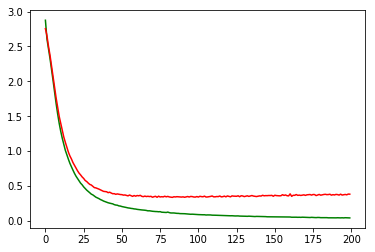

In [12]:
plt.plot(history.epoch, history.history['loss'], 'g')
plt.plot(history.epoch, history.history['val_loss'],'r')

In [13]:
loss, accuracy = model.evaluate(xtest,ytest)
print(accuracy)

241/241 [==============================] - 0s 145us/step
0.995850622406639


The neural network gives an accuracy of 99.5% on the test dataset for type1. The training set is divided as training and validation sets where 80% is for training the data and 20% is for validating the data. The above graph compares the training and validation losses. 

Let us now build a model for predicting the legendary type of pokemon. 

In [21]:
features2= pd.DataFrame(features.iloc[:,245:-2])
features2=features2.drop(['capture_rate'],axis=1)
features2=(features2-features2.min())/(features2.max()-features2.min())
features2=np.array(features2)

In [22]:
target2=pd.DataFrame(newdf['is_legendary'])
target=np.array(target2)
#since is_legendary contains only integers, they are converted into cateogrical values 
from keras.utils import to_categorical
target = to_categorical(target)
xtrain, xtest, ytrain, ytest = train_test_split(features2,target, test_size=0.3)




In [23]:
model = keras.Sequential([
    keras.layers.Dense(106, activation=tf.nn.tanh,
                       input_shape=(xtrain.shape[1],)),
    keras.layers.Dense(67, activation=tf.nn.tanh),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])



In [24]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [33]:
history2= model.fit(xtrain, ytrain, epochs=200, validation_split=0.2, verbose=2)

Train on 448 samples, validate on 112 samples
Epoch 1/200
 - 0s - loss: 0.2061 - acc: 0.9196 - val_loss: 0.2802 - val_acc: 0.8750
Epoch 2/200
 - 0s - loss: 0.2056 - acc: 0.9196 - val_loss: 0.2791 - val_acc: 0.8750
Epoch 3/200
 - 0s - loss: 0.2049 - acc: 0.9196 - val_loss: 0.2785 - val_acc: 0.8750
Epoch 4/200
 - 0s - loss: 0.2044 - acc: 0.9196 - val_loss: 0.2777 - val_acc: 0.8750
Epoch 5/200
 - 0s - loss: 0.2039 - acc: 0.9196 - val_loss: 0.2768 - val_acc: 0.8750
Epoch 6/200
 - 0s - loss: 0.2033 - acc: 0.9196 - val_loss: 0.2762 - val_acc: 0.8750
Epoch 7/200
 - 0s - loss: 0.2027 - acc: 0.9196 - val_loss: 0.2753 - val_acc: 0.8750
Epoch 8/200
 - 0s - loss: 0.2022 - acc: 0.9196 - val_loss: 0.2745 - val_acc: 0.8750
Epoch 9/200
 - 0s - loss: 0.2017 - acc: 0.9196 - val_loss: 0.2737 - val_acc: 0.8750
Epoch 10/200
 - 0s - loss: 0.2011 - acc: 0.9196 - val_loss: 0.2729 - val_acc: 0.8750
Epoch 11/200
 - 0s - loss: 0.2006 - acc: 0.9196 - val_loss: 0.2723 - val_acc: 0.8750
Epoch 12/200
 - 0s - loss: 0

Epoch 97/200
 - 0s - loss: 0.1592 - acc: 0.9487 - val_loss: 0.2154 - val_acc: 0.9018
Epoch 98/200
 - 0s - loss: 0.1588 - acc: 0.9487 - val_loss: 0.2148 - val_acc: 0.9107
Epoch 99/200
 - 0s - loss: 0.1584 - acc: 0.9509 - val_loss: 0.2143 - val_acc: 0.9107
Epoch 100/200
 - 0s - loss: 0.1580 - acc: 0.9509 - val_loss: 0.2139 - val_acc: 0.9107
Epoch 101/200
 - 0s - loss: 0.1576 - acc: 0.9509 - val_loss: 0.2133 - val_acc: 0.9196
Epoch 102/200
 - 0s - loss: 0.1572 - acc: 0.9509 - val_loss: 0.2127 - val_acc: 0.9196
Epoch 103/200
 - 0s - loss: 0.1568 - acc: 0.9509 - val_loss: 0.2123 - val_acc: 0.9196
Epoch 104/200
 - 0s - loss: 0.1564 - acc: 0.9509 - val_loss: 0.2117 - val_acc: 0.9196
Epoch 105/200
 - 0s - loss: 0.1560 - acc: 0.9509 - val_loss: 0.2110 - val_acc: 0.9196
Epoch 106/200
 - 0s - loss: 0.1556 - acc: 0.9509 - val_loss: 0.2105 - val_acc: 0.9196
Epoch 107/200
 - 0s - loss: 0.1552 - acc: 0.9509 - val_loss: 0.2100 - val_acc: 0.9196
Epoch 108/200
 - 0s - loss: 0.1548 - acc: 0.9509 - val_lo

Epoch 193/200
 - 0s - loss: 0.1270 - acc: 0.9554 - val_loss: 0.1724 - val_acc: 0.9286
Epoch 194/200
 - 0s - loss: 0.1268 - acc: 0.9554 - val_loss: 0.1721 - val_acc: 0.9286
Epoch 195/200
 - 0s - loss: 0.1265 - acc: 0.9554 - val_loss: 0.1716 - val_acc: 0.9286
Epoch 196/200
 - 0s - loss: 0.1262 - acc: 0.9554 - val_loss: 0.1713 - val_acc: 0.9286
Epoch 197/200
 - 0s - loss: 0.1260 - acc: 0.9554 - val_loss: 0.1710 - val_acc: 0.9286
Epoch 198/200
 - 0s - loss: 0.1257 - acc: 0.9554 - val_loss: 0.1707 - val_acc: 0.9286
Epoch 199/200
 - 0s - loss: 0.1255 - acc: 0.9554 - val_loss: 0.1703 - val_acc: 0.9286
Epoch 200/200
 - 0s - loss: 0.1252 - acc: 0.9554 - val_loss: 0.1699 - val_acc: 0.9286


In [35]:
model.fit(xtest,ytest,epochs=100)

Epoch 1/100
241/241 [==============================] - 0s 104us/step - loss: 0.1233 - acc: 0.9544
Epoch 2/100
241/241 [==============================] - 0s 41us/step - loss: 0.1231 - acc: 0.9544
Epoch 3/100
241/241 [==============================] - 0s 52us/step - loss: 0.1230 - acc: 0.9544
Epoch 4/100
241/241 [==============================] - 0s 62us/step - loss: 0.1229 - acc: 0.9544
Epoch 5/100
241/241 [==============================] - 0s 52us/step - loss: 0.1227 - acc: 0.9544
Epoch 6/100
241/241 [==============================] - 0s 52us/step - loss: 0.1226 - acc: 0.9544
Epoch 7/100
241/241 [==============================] - 0s 52us/step - loss: 0.1224 - acc: 0.9544
Epoch 8/100
241/241 [==============================] - 0s 52us/step - loss: 0.1223 - acc: 0.9544
Epoch 9/100
241/241 [==============================] - 0s 52us/step - loss: 0.1221 - acc: 0.9544
Epoch 10/100
241/241 [==============================] - 0s 104us/step - loss: 0.1220 - acc: 0.9544
Epoch 11/100
241/241 [=====

241/241 [==============================] - 0s 73us/step - loss: 0.1126 - acc: 0.9585
Epoch 85/100
241/241 [==============================] - 0s 62us/step - loss: 0.1125 - acc: 0.9627
Epoch 86/100
241/241 [==============================] - 0s 52us/step - loss: 0.1124 - acc: 0.9627
Epoch 87/100
241/241 [==============================] - 0s 52us/step - loss: 0.1123 - acc: 0.9627
Epoch 88/100
241/241 [==============================] - 0s 52us/step - loss: 0.1122 - acc: 0.9627
Epoch 89/100
241/241 [==============================] - 0s 73us/step - loss: 0.1121 - acc: 0.9627
Epoch 90/100
241/241 [==============================] - 0s 104us/step - loss: 0.1120 - acc: 0.9627
Epoch 91/100
241/241 [==============================] - 0s 83us/step - loss: 0.1118 - acc: 0.9627
Epoch 92/100
241/241 [==============================] - 0s 73us/step - loss: 0.1117 - acc: 0.9627
Epoch 93/100
241/241 [==============================] - 0s 73us/step - loss: 0.1116 - acc: 0.9627
Epoch 94/100
241/241 [==========

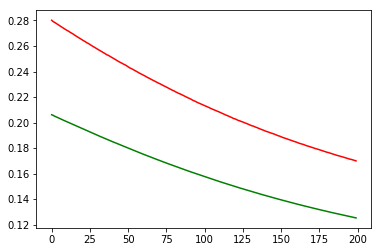

In [40]:
plt.plot(history2.epoch, history2.history['loss'], 'g')
plt.plot(history2.epoch, history2.history['val_loss'],'r')

In [36]:
loss, accuracy = model.evaluate(xtest,ytest)
print(accuracy)

241/241 [==============================] - 0s 83us/step
0.9626556016597511


## Algorithm conclusions

The two algorithms gives an accuracy of more than 80% but the neural network gives a better accuracy when compared to KNN on both targets. 

In [41]:
model.save('pokemon_final.h5')